# Testing bluesky + EPICS

Following the bluesky tutorial https://nsls-ii.github.io/bluesky/tutorial.html with simulated and live motors

In [ ]:
# April 2022
# awojdyla@lbl.gov

In [2]:
import epics
import bluesky
#import numpy
#import matplotlib.pyplot as plt
#import time 

In [3]:
from bluesky import RunEngine
RE = RunEngine({})

In [4]:
# some issues here -- not critical
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

# Make plots update live while scans run.
from bluesky.utils import install_kicker
install_kicker()

NotImplementedError: The matplotlib backend module://matplotlib_inline.backend_inline is not yet supported.

In [5]:
from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

1

In [6]:
from bluesky.utils import ProgressBarManager
RE.waiting_hook = ProgressBarManager()

### Connecting to EPICS motors
We had some issues here witht the picoscale interformeter -- we need to use caproto to talk to it (ophyd's motor does not work directly out of the box)

from: https://nsls-ii.github.io/bluesky/tutorial.html

```
from ophyd import EpicsMotor
nano_top_x = EpicsMotor('XF:31ID-ES{Dif:Nano-Ax:TopX}Mtr', name='nano_top_x')
```
see also:

https://blueskyproject.io/ophyd/generated/ophyd.epics_motor.EpicsMotor.html#:~:text=class%20ophyd.epics_motor.EpicsMotor%28prefix%3D%27%27%2C%20%2A%2C%20name%2C%20kind%3DNone%2C%20read_attrs%3DNone%2C%20configuration_attrs%3DNone%2C%20parent%3DNone%2C,are%20passed%20through%20to%20the%20base%20class%2C%20Positioner




In [25]:
from ophyd import EpicsMotor
import ophyd
ophyd.set_cl('caproto')

#that does not work
#det = ophyd.EpicsMotor('BL531:PS:POS_0', name='picoscale') 
#det.read()

det_ps = ophyd.EpicsSignal('BL531:PS:POS_0', name='picoscale')
# do not do a read in the same cell! too fast

#this works
det_ps.wait_for_connection(timeout=2.0)
det_ps.read()

{'picoscale': {'value': -1983179686, 'timestamp': 1651275975.901231}}

In [19]:
## works!
det_hxp = EpicsMotor('BL531:hxp:c0:m3', name='hxp hexapod')
det_hxp.wait_for_connection(timeout=2.0)
det_hxp.read()

OrderedDict([('hxp hexapod',
              {'value': -8.260530000000001, 'timestamp': 631152000.0}),
             ('hxp hexapod_user_setpoint',
              {'value': -8.260530000000001, 'timestamp': 1651274112.3965483})])

In [23]:
hexpod_z_mm = epics.caget('BL531:hxp:c0:m3')
print("hexapod z position (hexapod status): %1.6f mm" % (hexpod_z_mm))

hexapod z position (hexapod status): -8.260530 mm


In [20]:
#worked at some point... needs to be launched
det_virtual = EpicsMotor('IOC:m1', name='virtual motor')
det_virtual.wait_for_connection(timeout=2.0)
det_virtual.read()

TimeoutError: Failed to connect to all signals: virtual motor.user_readback (IOC:m1.RBV), virtual motor.user_setpoint (IOC:m1.VAL), virtual motor.user_offset (IOC:m1.OFF), virtual motor.user_offset_dir (IOC:m1.DIR), virtual motor.offset_freeze_switch (IOC:m1.FOFF), virtual motor.set_use_switch (IOC:m1.SET), virtual motor.velocity (IOC:m1.VELO), virtual motor.acceleration (IOC:m1.ACCL), virtual motor.motor_egu (IOC:m1.EGU), virtual motor.motor_is_moving (IOC:m1.MOVN), virtual motor.motor_done_move (IOC:m1.DMOV), virtual motor.high_limit_switch (IOC:m1.HLS), virtual motor.low_limit_switch (IOC:m1.LLS), virtual motor.high_limit_travel (IOC:m1.HLM), virtual motor.low_limit_travel (IOC:m1.LLM), virtual motor.direction_of_travel (IOC:m1.TDIR), virtual motor.motor_stop (IOC:m1.STOP), virtual motor.home_forward (IOC:m1.HOMF), virtual motor.home_reverse (IOC:m1.HOMR); Pending operations: EpicsMotor(prefix='IOC:m1', name='virtual motor', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu'])._pos_changed[value] subscription, EpicsMotor(prefix='IOC:m1', name='virtual motor', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu'])._move_changed[value] subscription

In [ ]:
epics.caget('IOC:m1')

### Simulated detectors

In [26]:
from ophyd.sim import det1, det2  # two simulated detectors
from bluesky.plans import count
#dets = [det1, det2]   # a list of any number of detectors

dets = [det_ps, det_hxp]   # a list of any number of detectors

RE(count(dets))



Transient Scan ID: 1     Time: 2022-04-29 16:46:22
Persistent Unique Scan ID: '8c99bdd4-7f2f-473b-96f4-601df48ad008'
New stream: 'primary'
+-----------+------------+-------------+------------+
|   seq_num |       time | hxp hexapod |  picoscale |
+-----------+------------+-------------+------------+
|         1 | 16:46:22.9 |    -8.26053 | -1983077098 |
+-----------+------------+-------------+------------+
generator count ['8c99bdd4'] (scan num: 1)





('8c99bdd4-7f2f-473b-96f4-601df48ad008',)



Transient Scan ID: 2     Time: 2022-04-29 16:46:54
Persistent Unique Scan ID: '9118cb84-9870-470c-96f5-b9feaa1059d2'
New stream: 'primary'
+-----------+------------+-------------+------------+
|   seq_num |       time | hxp hexapod |  picoscale |
+-----------+------------+-------------+------------+
|         1 | 16:46:54.9 |    -8.26053 | -1983157320 |
|         2 | 16:46:55.1 |    -8.26053 | -1983186464 |
|         3 | 16:46:55.3 |    -8.26053 | -1983122829 |
|         4 | 16:46:55.5 |    -8.26053 | -1983165160 |
|         5 | 16:46:55.7 |    -8.26053 | -1983154571 |
+-----------+------------+-------------+------------+
generator count ['9118cb84'] (scan num: 2)





Transient Scan ID: 3     Time: 2022-04-29 16:46:56
Persistent Unique Scan ID: '603059c6-9653-4102-bfd9-be0d16325158'
New stream: 'primary'
+-----------+------------+-------------+------------+
|   seq_num |       time | hxp hexapod |  picoscale |
+-----------+------------+-------------+------------+
|         1 | 16:46

('98292c83-d7ea-427e-a596-763b848f45bc',)

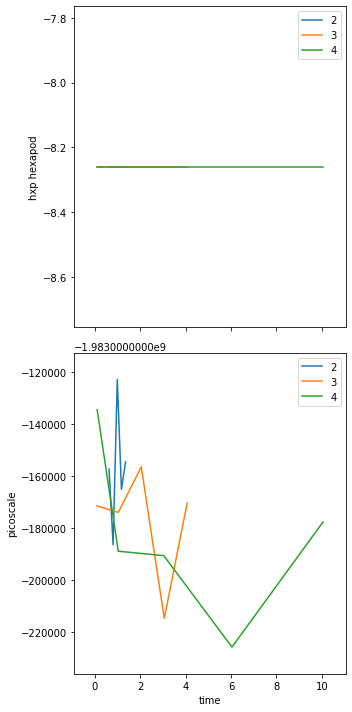

In [27]:
# five consecutive readings
RE(count(dets, num=5))

# five sequential readings separated by a 1-second delay
RE(count(dets, num=5, delay=1))

# a variable delay
RE(count(dets, num=5, delay=[1, 2, 3, 4]))



Transient Scan ID: 7     Time: 2022-04-29 17:22:27
Persistent Unique Scan ID: '76294f93-5388-4b2e-9054-368675719786'
New stream: 'primary'
+-----------+------------+-------------+------------+
|   seq_num |       time | hxp hexapod |  picoscale |
+-----------+------------+-------------+------------+
|         1 | 17:22:27.5 |    -8.00000 | 1016895013 |
hxp hexapod:  11%|██████▉                                                        | 0.01096/0.1 [00:00<00:00, 10.18s/mm]
hxp hexapod:  94%|██████████████████████████████████████████████████████████▉    | 0.09361/0.1 [00:00<00:00,  3.35s/mm]
hxp hexapod:  94%|██████████████████████████████████████████████████████████▉    | 0.09361/0.1 [00:00<00:00,  3.45s/mm]
hxp hexapod: 100%|███████████████████████████████████████████████████████████████████| 0.1/0.1 [00:00<00:00,  5.18s/mm]
hxp hexapod: 100%|███████████████████████████████████████████████████████████████████| 0.1/0.1 [00:00<00:00,  5.24s/mm]
hxp hexapod [In progress. No progress bar a

hxp hexapod [In progress. No progress bar available.]                                                                  
                                                                                                                       
|        10 | 17:22:32.9 |    -7.10012 |  117389869 |
hxp hexapod:  10%|█████▉                                                     | 0.01007/0.10012 [00:00<00:00, 10.79s/mm]
hxp hexapod:  93%|██████████████████████████████████████████████████████▊    | 0.09295/0.10012 [00:00<00:00,  3.34s/mm]
hxp hexapod:  93%|██████████████████████████████████████████████████████▊    | 0.09295/0.10012 [00:00<00:00,  3.41s/mm]
hxp hexapod: 100%|███████████████████████████████████████████████████████████| 0.10012/0.10012 [00:00<00:00,  5.13s/mm]
hxp hexapod: 100%|███████████████████████████████████████████████████████████| 0.10012/0.10012 [00:00<00:00,  5.19s/mm]
hxp hexapod [In progress. No progress bar available.]                                                     

('76294f93-5388-4b2e-9054-368675719786',)

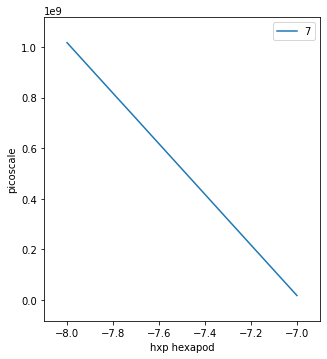

In [44]:
from bluesky.plans import scan
motors = det_hxp
dets = [det_ps]
RE(scan(dets, motors, -8, -7, 11))

In [48]:
header.table()

,time,hxp hexapod,hxp hexapod_user_setpoint,picoscale
seq_num,,,,
1,2022-04-30 00:22:27.503547430,-8.00000,-8.0,1016895013
2,2022-04-30 00:22:28.126782656,-7.89997,-7.9,916854806
3,2022-04-30 00:22:28.735365152,-7.79994,-7.8,816850605
4,2022-04-30 00:22:29.337175369,-7.69992,-7.7,717223508
5,2022-04-30 00:22:29.948419809,-7.59992,-7.6,617049937
6,2022-04-30 00:22:30.555237055,-7.49993,-7.5,517127091
7,2022-04-30 00:22:31.163182020,-7.39996,-7.4,417160277
8,2022-04-30 00:22:31.775228977,-7.30000,-7.3,317074994
9,2022-04-30 00:22:32.389083147,-7.20005,-7.2,217184663


In [41]:
det_hxp.move(-8)

MoveStatus(done=True, pos=hxp hexapod, elapsed=0.0, success=True, settle_time=0.0)

In [43]:
det_hxp.position

-8.000020000000001

In [42]:
move_done = epics.caput('BL531:hxp:c0:m3',-8)

In [ ]:
76294f93-5388-4b2e-9054-368675719786

In [46]:
header = db[-1]

In [60]:
a = header.data('picoscale')

<generator object Header.data at 0x000002078863B740>

In [ ]:
import matplotlib.pyplot as plt
plot. 

In [56]:
help(header)

Help on Header in module databroker.v1 object:

class Header(builtins.object)
 |  Header(datasource)
 |  
 |  This supports the original Header API but implemented on intake's Entry.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __getitem__(self, k)
 |  
 |  __init__(self, datasource)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  config_data(self, device_name)
 |      Extract device configuration data from Event Descriptors.
 |      
 |      This refers to the data obtained from ``device.read_configuration()``.
 |      
 |      See example below. The result is structed as a [...deep breath...]
 |      dictionary of lists of dictionaries because:
 |      
 |      * The device might have been read in multiple event streams
 |        ('primary', 'baseline', etc.). Each stream name is a key in the
 |        outer dictionary.
 |      * The configuration is typically read once per eve